### <font color='blue'>Prevendo a Relação do Preço de Commodities e Mudanças Climáticas ao Longo do Tempo</font>
### <font color='blue'>Long Short Term Memory (LSTM)</font>

## Instalando e Carregando os Pacotes

In [3]:
!pip install -q tensorflow==2.11.0

In [5]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, explained_variance_score
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

## Carregando os Dados

In [7]:
df = pd.read_csv('dados/dataset.csv')

In [8]:
df.shape

(124, 12)

In [9]:
df.head()

,data,petroleo_bruto,minerio_ferro,ouro,arroz,feijao,milho,soja,trigo,cafe,algodao,umidade
0,2012-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
1,2013-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2,2013-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
3,2013-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
4,2013-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


In [10]:
# Converte a coluna de data em índice
df.index = pd.to_datetime(df['data'], format = '%Y.%m.%d')

In [11]:
del df['data']

In [12]:
df.head()

,petroleo_bruto,minerio_ferro,ouro,arroz,feijao,milho,soja,trigo,cafe,algodao,umidade
data,,,,,,,,,,,
2012-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
2013-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2013-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
2013-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
2013-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


Text(0.5, 0, '\nData')

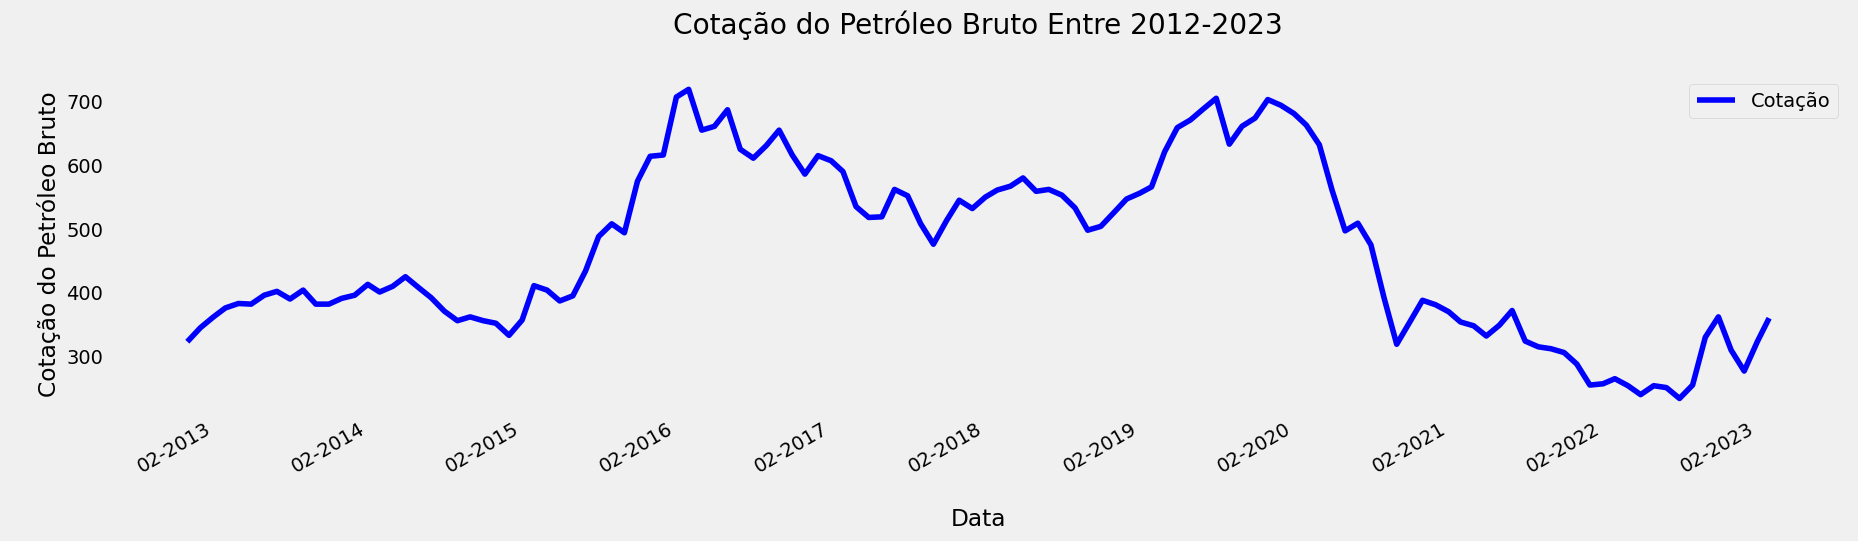

In [13]:
# Plot
plt.figure(figsize = (20,5))
plt.grid()
plt.plot(df.index, df['petroleo_bruto'], color = 'blue')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() 
plt.legend(['Cotação'], loc='best')
plt.title('Cotação do Petróleo Bruto Entre 2012-2023\n')
plt.ylabel('\nCotação do Petróleo Bruto')
plt.xlabel('\nData')

## Arquitetura Long Short Term Memory (LSTM)

Leia o manual em pdf no Capítulo 5.

### Pré-Processamento dos Dados

In [14]:
# Proporção de dados para treino e teste
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

In [15]:
# Define o tamanho das amostras
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

In [16]:
print('Tamanho da Amostra de Treino:', len(train))
print('Tamanho da Amostra de Teste:', len(test))

Tamanho da Amostra de Treino: 99
Tamanho da Amostra de Teste: 25


In [17]:
print(train.shape)
train.head()

(99, 11)


,petroleo_bruto,minerio_ferro,ouro,arroz,feijao,milho,soja,trigo,cafe,algodao,umidade
data,,,,,,,,,,,
2012-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
2013-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2013-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
2013-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
2013-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


In [18]:
# Variáveis preditoras
variaveis_preditoras = ['minerio_ferro', 
                        'ouro', 
                        'arroz', 
                        'feijao', 
                        'milho', 
                        'soja', 
                        'trigo', 
                        'cafe', 
                        'algodao', 
                        'umidade']

In [19]:
# Prepara o padronizador das variáveis preditoras
scaler_preditores = MinMaxScaler()

In [20]:
# Fit nos dados de treino
scaler_preditores = scaler_preditores.fit(train[variaveis_preditoras].to_numpy())

In [21]:
# Transform nos dados de treino
train.loc[:, variaveis_preditoras] = scaler_preditores.transform(train[variaveis_preditoras].to_numpy())

In [22]:
train.head()

,petroleo_bruto,minerio_ferro,ouro,arroz,feijao,milho,soja,trigo,cafe,algodao,umidade
data,,,,,,,,,,,
2012-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302,0.109026,0.617026,0.366984,0.843364
2013-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321,0.044200,0.815738,0.007619,0.983088
2013-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992,0.006514,0.904388,0.073016,0.632580
2013-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639,0.000000,0.717805,0.163492,0.780147
2013-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621,0.010236,0.789608,0.520317,0.899990


In [23]:
# Transform nos dados de teste
test.loc[:, variaveis_preditoras] = scaler_preditores.transform(test[variaveis_preditoras].to_numpy())

In [24]:
test.head()

,petroleo_bruto,minerio_ferro,ouro,arroz,feijao,milho,soja,trigo,cafe,algodao,umidade
data,,,,,,,,,,,
2021-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342,0.455180,0.707023,0.548889,0.265874
2021-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870,0.515974,0.732180,0.017143,0.437683
2021-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525,0.530397,0.708895,0.444127,0.349664
2021-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824,0.593207,0.808476,0.181905,0.645800
2021-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462,0.641749,0.866202,0.436825,0.577974


In [25]:
# Padronizador da variável alvo
scaler_target = MinMaxScaler()

In [26]:
# Fit nos dados de treino
scaler_target = scaler_target.fit(train[['petroleo_bruto']])

In [27]:
# Transform nos dados de treino
train['petroleo_bruto'] = scaler_target.transform(train[['petroleo_bruto']])

In [28]:
train['petroleo_bruto'].head()

data
2012-12-01    0.0100
2013-01-01    0.0650
2013-02-01    0.1075
2013-03-01    0.1425
2013-04-01    0.1600
Name: petroleo_bruto, dtype: float64

In [29]:
# Transform nos dados de teste
test['petroleo_bruto'] = scaler_target.transform(test[['petroleo_bruto']])

In [30]:
test['petroleo_bruto'].head()

data
2021-03-01    0.0875
2021-04-01    0.0725
2021-05-01    0.0325
2021-06-01    0.0750
2021-07-01    0.1325
Name: petroleo_bruto, dtype: float64

In [31]:
# Função para criar o dataset final
def createDataset(X, y, time_steps):
    
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

In [32]:
time_steps = 3

In [33]:
X_train, y_train = createDataset(train, train.petroleo_bruto, time_steps)

In [34]:
X_test, y_test = createDataset(test, test.petroleo_bruto, time_steps)

In [35]:
print(X_train.shape, y_train.shape)

(96, 3, 11) (96,)


In [36]:
print(X_test.shape, y_test.shape)

(22, 3, 11) (22,)


## Modelagem com LSTM

In [38]:
# Cria o modelo
modelo_lstm = tf.keras.Sequential()
modelo_lstm.add(tf.keras.layers.LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
modelo_lstm.add(tf.keras.layers.Dropout(rate = 0.2))
modelo_lstm.add(tf.keras.layers.Dense(units = 1))

In [39]:
# Compila o modelo
modelo_lstm.compile(loss = 'mse', optimizer = 'adam')

In [40]:
modelo_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               71680     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 71,809
Trainable params: 71,809
Non-trainable params: 0
_________________________________________________________________


### Treinamento do Modelo

In [41]:
%%time
modelo_lstm_history = modelo_lstm.fit(X_train, 
                                      y_train,
                                      epochs = 100,
                                      batch_size = 32,
                                      validation_split = 0.1,
                                      shuffle = False)

Epoch 1/100
3/3 [==============================] - 2s 167ms/step - loss: 0.2698 - val_loss: 0.0340
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1021 - val_loss: 0.0396
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0331 - val_loss: 0.1045
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0395 - val_loss: 0.1779
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0592 - val_loss: 0.1906
Epoch 6/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0589 - val_loss: 0.1517
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0413 - val_loss: 0.1053
Epoch 8/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0311 - val_loss: 0.0722
Epoch 9/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0298 - val_loss: 0.0542
Epoch 10/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0284 - val_loss: 0.0477
Epoch 11/100
3/3 [

3/3 [==============================] - 0s 8ms/step - loss: 0.0077 - val_loss: 0.0290
Epoch 85/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0075 - val_loss: 0.0238
Epoch 86/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0085 - val_loss: 0.0219
Epoch 87/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0076 - val_loss: 0.0256
Epoch 88/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.0307
Epoch 89/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0078 - val_loss: 0.0302
Epoch 90/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0251
Epoch 91/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0085 - val_loss: 0.0235
Epoch 92/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0090 - val_loss: 0.0275
Epoch 93/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 0.0313
Epoch 94/100
3/3 [===============

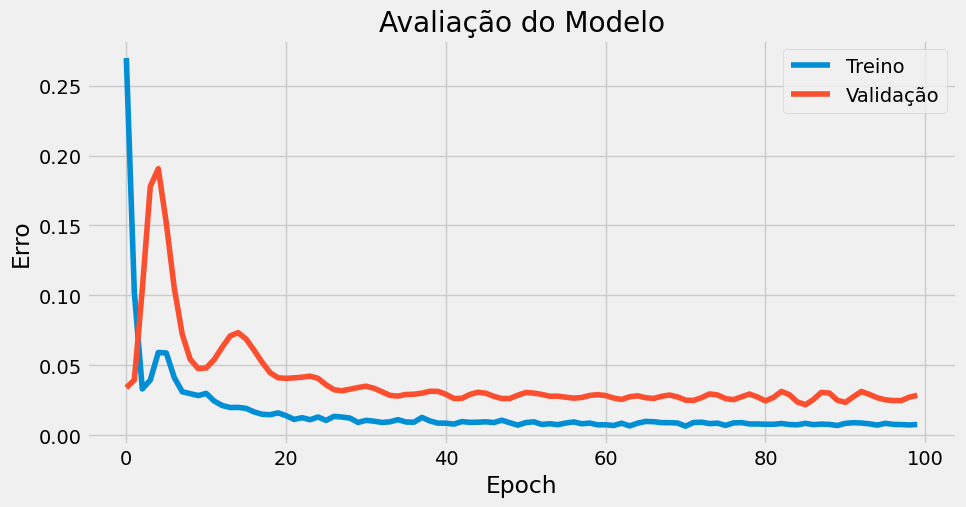

In [42]:
# Plot
plt.plot(modelo_lstm_history.history['loss'])
plt.plot(modelo_lstm_history.history['val_loss'])
plt.title('Avaliação do Modelo')
plt.ylabel('Erro')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Validação'], loc = 'upper right')
plt.show()

### Previsões com Dados de Teste

In [43]:
y_pred = modelo_lstm.predict(X_test)

1/1 [==============================] - 0s 287ms/step


In [44]:
y_pred

array([[0.16794625],
       [0.17216974],
       [0.18661848],
       [0.18791853],
       [0.14533529],
       [0.09777407],
       [0.07498109],
       [0.07253145],
       [0.05551539],
       [0.05408861],
       [0.0401281 ],
       [0.03097823],
       [0.03999877],
       [0.05231631],
       [0.06747044],
       [0.05885798],
       [0.014391  ],
       [0.01984413],
       [0.12128963],
       [0.19768947],
       [0.18700893],
       [0.15152666]], dtype=float32)

### Invertendo a Escala

In [45]:
# Invertemos a escala para visualizar o valor real e a previsão
y_train_inv = scaler_target.inverse_transform(y_train.reshape(1, -1))
y_test_inv = scaler_target.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = scaler_target.inverse_transform(y_pred.reshape(1,-1))

In [46]:
# Ajusta o shape
y_train_inv = y_train_inv.flatten()
y_test_inv = y_test_inv.flatten()
y_pred_inv = y_pred_inv.flatten()

### Plot

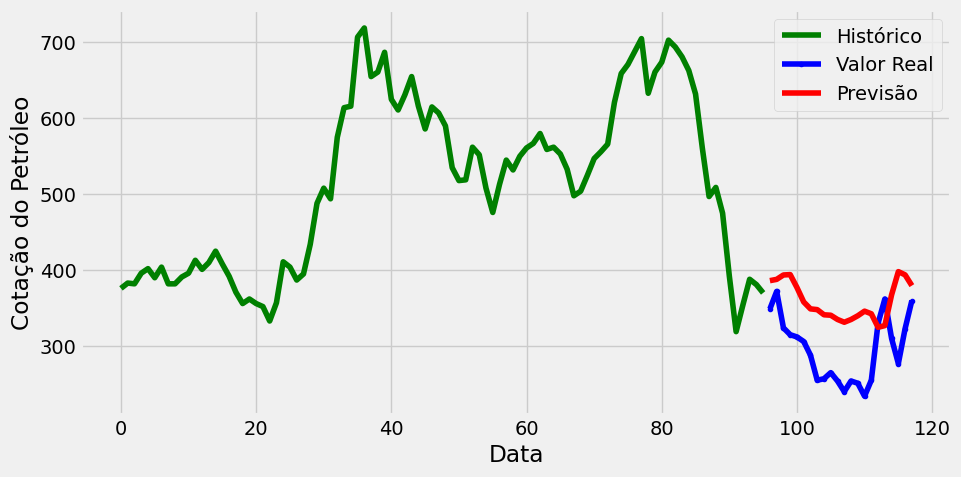

In [47]:
# Plot
plt.plot(np.arange(0, len(y_train)), 
         y_train_inv, 
         color = 'green', 
         label = "Histórico")

plt.plot(np.arange(len(y_train), 
                   len(y_train) + len(y_test)), 
         y_test_inv, 
         color = 'blue', 
         marker = '.', 
         label = "Valor Real")

plt.plot(np.arange(len(y_train), 
                   len(y_train) + len(y_test)), 
         y_pred_inv, 
         color = 'red', 
         label = "Previsão")

plt.ylabel('Cotação do Petróleo')
plt.xlabel('Data')
plt.legend()
plt.show();

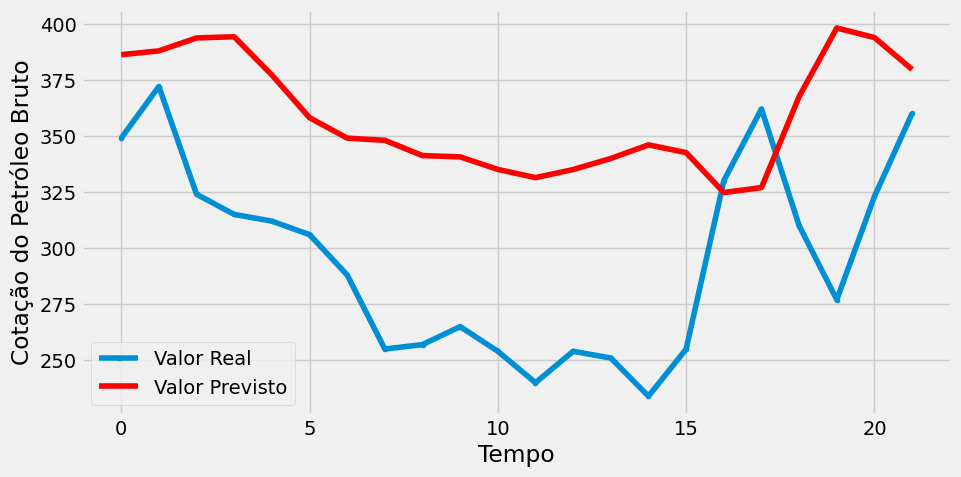

In [48]:
# Plot apenas do valor real x valor previsto
plt.plot(y_test_inv, marker = '.', label = "Valor Real")
plt.plot(y_pred_inv, color = 'red', label = "Valor Previsto")
plt.ylabel('Cotação do Petróleo Bruto')
plt.xlabel('Tempo')
plt.legend()
plt.show();

### Avaliação

Usaremos as mesmas métricas usadas na versão do modelo MLP.

In [49]:
# Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [50]:
# Imprime as métricas

MDA_lstm = mda(y_test_inv, y_pred_inv)
print('MDA:', MDA_lstm)

MAE_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE:', MAE_lstm)

MSE_lstm = mean_squared_error(y_test_inv, y_pred_inv)
print('MSE:', MSE_lstm)

RMSE_lstm = mean_squared_error(y_test_inv, y_pred_inv, squared = False)
print('RMSE:', RMSE_lstm)

EVS_lstm = explained_variance_score(y_test_inv, y_pred_inv)
print('EVS Score:', EVS_lstm)

MDA: 0.42857142857142855
MAE: 67.46196816184305
MSE: 5414.120078404476
RMSE: 73.58070452506198
EVS Score: 0.2496518940281478


In [51]:
# Salva o modelo
def save_model(model):
    json_model = model.to_json()
    open('modelos/modelo_lstm.json', 'w').write(json_model)
    model.save_weights('modelos/modelo_lstm.h5', overwrite = True)

In [52]:
save_model(modelo_lstm)